# Intro To GraphQL For Data Scientists

![](../img/graphql.png)

This notebook covers querying GraphQL using Python and using GraphQL as a data source for graph data science with Neo4j.

Outline:

* Querying The Meetup API
* Working with GraphQL data in a DataFrame
* Neo4j and Graph Data Science
* Visualizing Graph Data
* Exposing Data Science Via GraphQL

# Querying The Meetup API 

![](../img/meetup.png)

Meetup offers a GraphQL API First, you'll need an authorization token to query the Meetup API. The Meetup API uses the OAuth flow to manage tokens so you'll need to follow the steps descried here. Alternatively someone has created a helpful app to generate Meetup tokens - just know that isn't an official Meetup app and you are sharing your data with a 3rd party...

A GraphQL request is an HTTP POST request to `https://api.meetup.com/gql`. Authorization is done by setting an Authorization header on the HTTP request using a bearer token.

```
{"Authorization": "Bearer <YOUR_TOKEN_HERE?"}
```

We will be using the GQL Python GraphQL client

```
pip install gql
```

In [59]:
import os

# Replace with your Meetup API token
# See: https://www.meetup.com/api/authentication/#p02-server-flow-section
MEETUP_SECRET = os.getenv('MEETUP_SECRET')

In [60]:
import pprint
from gql import Client, gql
from gql.transport.aiohttp import AIOHTTPTransport

# Select your transport with a defined url endpoint
transport = AIOHTTPTransport(
    url="https://api.meetup.com/gql",
    headers={"Authorization": "Bearer " + MEETUP_SECRET},
)


# Create a GraphQL client using the defined transport
client = Client(transport=transport, fetch_schema_from_transport=False)

# Provide a GraphQL query
query = gql(
    """
    query { self { id name } }
"""
)

# Execute the query on the transport
result = await client.execute_async(query)
print(result)

{'self': {'id': '40626372', 'name': 'Will Lyon'}}


## Find The Data Umbrella Meetup Group

![](../img/graphql1.png)

Notice how the nested selection set in the GraphQL query is describing a traversal through the data graph.

```GraphQL
query {
      groupByUrlname(urlname: "data-umbrella") {
        id
        name
        link
        topics {
          name
        }
      }
    }
```



In [22]:
# Find the Data Umbrella Meetup group and its topics

query = gql(
    """
    query {
      groupByUrlname(urlname: "data-umbrella") {
        id
        name
        link
        topics {
          name
        }
      }
    }
    """
)


result = await client.execute_async(query)
pprint.pprint(result)

{'groupByUrlname': {'id': '33067477',
                    'link': 'https://www.meetup.com/data-umbrella',
                    'name': 'Data Umbrella',
                    'topics': [{'name': 'Business Analytics'},
                               {'name': 'Artificial Intelligence Applications'},
                               {'name': 'Data Visualization'},
                               {'name': 'Data Analytics'},
                               {'name': 'Open Source'},
                               {'name': 'Data Science'},
                               {'name': 'Data Science using Python'},
                               {'name': 'Python'},
                               {'name': 'Deep Learning'},
                               {'name': 'Artificial Intelligence'},
                               {'name': 'Machine Learning'}]}}


## Find Data Umbrella's Upcoming Events

![](../img/graphql2.png)

This query uses a "connection type" to represent connections. These connection types can be useful for pagination and metadata about the relationships (think relationship properties).

```GraphQL
query {
      groupByUrlname(urlname: "data-umbrella") {
        name
        upcomingEvents(input: {first: 10}) {
          count
          edges {
            node {
              id
              title
              eventUrl
              dateTime
              host {
                name
              }
            }
          }
        }
      }
    }
```



In [66]:
# Find upcoming events and the host

query = gql(
    """
    query {
      groupByUrlname(urlname: "data-umbrella") {
        name
        upcomingEvents(input: {first: 10}) {
          count
          edges {
            node {
              id
              title
              eventUrl
              dateTime
              host {
                name
              }
            }
          }
        }
      }
    }
    """
)


result = await client.execute_async(query)
pprint.pprint(result)

{'groupByUrlname': {'name': 'Data Umbrella',
                    'upcomingEvents': {'count': 2,
                                       'edges': [{'node': {'dateTime': '2022-04-26T12:00-04:00',
                                                           'eventUrl': 'https://www.meetup.com/data-umbrella/events/284764217',
                                                           'host': {'name': 'Beryl '
                                                                            'Kanali'},
                                                           'id': '284764217!chp',
                                                           'title': 'Introduction '
                                                                    'to '
                                                                    'GraphQL '
                                                                    'for Data '
                                                                    'Scientists'}},
                        

## Who RSVPd For This Event?

![](../img/graphql3.png)

```GraphQL
query {
      event(id: "284764217!chp") {
        title
        tickets {
          count
          edges {
            node {
              status
              createdAt
              user {
                name
              }
              
            }
          }
        }
      }
    }
```

In [67]:
# Who RSVPd for this event?

query = gql(
    """
    query {
      event(id: "284764217!chp") {
        title
        tickets {
          count
          edges {
            node {
              status
              createdAt
              user {
                name
              }
              
            }
          }
        }
      }
    }
    """
)


result = await client.execute_async(query)
pprint.pprint(result)

{'event': {'tickets': {'count': 78,
                       'edges': [{'node': {'createdAt': '2022-04-21T21:40:56.909Z[UTC]',
                                           'status': 'YES',
                                           'user': {'name': 'Marie F'}}},
                                 {'node': {'createdAt': '2022-04-21T21:40:56.909Z[UTC]',
                                           'status': 'YES',
                                           'user': {'name': 'Therron Ricks'}}},
                                 {'node': {'createdAt': '2022-04-21T21:40:56.909Z[UTC]',
                                           'status': 'YES',
                                           'user': {'name': 'Erika R'}}},
                                 {'node': {'createdAt': '2022-04-21T21:40:56.910Z[UTC]',
                                           'status': 'YES',
                                           'user': {'name': 'Pierre DeBois'}}},
                                 {'node': {'createdAt': '202

## Search For Groups By Keyword

![](../img/graphql4.png)


Note the use of the inline fragment to handle an abstract type in GraphQL.
```GraphQL
... on Group {
  name
  urlname
  pastEvents(input: {first: 10}) {
    count
  }
  topics {
    name
  }
}
```

In [33]:
# Group search by keyword ("data" or similar)

query = gql(
    """
    query { 
      keywordSearch(filter: {query: "data", lon: -122.42, lat: 37.78, source: GROUPS }) {
        count
        edges {
          node {
            result {
              ... on Group {
                name
                urlname
                pastEvents(input: {first: 10}) {
                  count
                }
                topics {
                  name
                }
              }
            }
          }
        }
      }
    }
    """
)


result = await client.execute_async(query)
groups_list = result["keywordSearch"]["edges"]
pprint.pprint(groups_list)

[{'node': {'result': {'name': 'Open Data Bay Area',
                      'pastEvents': {'count': 158},
                      'topics': [{'name': 'Predictive Analytics'},
                                 {'name': 'Data Analytics'},
                                 {'name': 'Open Data'},
                                 {'name': 'Data Mining'},
                                 {'name': 'Open Government'},
                                 {'name': 'Big Data'},
                                 {'name': 'Web of Data'},
                                 {'name': 'Semantic Web'},
                                 {'name': 'Data Science'},
                                 {'name': 'Data Journalism'},
                                 {'name': 'Machine Learning'}],
                      'urlname': 'Open-Data-Bay-Area'}}},
 {'node': {'result': {'name': 'Data for Good',
                      'pastEvents': {'count': 118},
                      'topics': [{'name': 'Data Science'},
                   

# Working With GraphQL Data In A DataFrame

In [42]:
# Let's see how we can work with this data in a DataFrame

import pandas as pd

In [57]:
# We'll use DataFrame.from_dict to create a DataFrame from the GraphQL response data
# Then pull out the integer value for pastEvents and the list of topics

df = pd.DataFrame.from_dict([x['node']['result'] for x in groups_list])

# {count: 3} ==> 3
df['pastEvents'] = df['pastEvents'].apply(lambda x: x['count']) 

# [{name: "AI"}, {name: "BI"}] ==> ["AI", "BI"]
df['topics'] = df['topics'].apply(lambda x: [f['name'] for f in x]) 
df

,name,urlname,pastEvents,topics
0,Open Data Bay Area,Open-Data-Bay-Area,158,"[Predictive Analytics, Data Analytics, Open Da..."
1,Data for Good,DataScienceforGood,118,"[Data Science, Social Impact, Open Data, Machi..."
2,SF - Bay Area Data Science Initiative,SF-Bay-Area-Data-Science-Initiative,150,"[Python, Business Intelligence, Hadoop, Big Da..."
3,San Francisco Data Science Networking Group,san-francisco-data-science-networking-group,20,"[Artificial Intelligence, Open Source, Data Vi..."
4,Data on Kubernetes community,Data-on-Kubernetes-community,151,"[Software Development, Configuration Managemen..."
5,Data Mash,data-mash,0,"[Data Management, Data Science using Python, D..."
6,"Data, Cloud and AI in San Francisco",big-data-developers-in-san-francisco,61,"[Data Visualization, Artificial Intelligence, ..."
7,Data Science Salon | San Francisco,sfdata,128,"[Business Analytics, Big Data, Business Intell..."
8,"Big Data, San Francisco",BigDataSanFran,76,"[Social Networking, Open Source, Business Stra..."
9,Big Data San Francisco,meetup-group-zmruyyov,10,"[Cloud Computing, Big Data, Web Analytics, Con..."


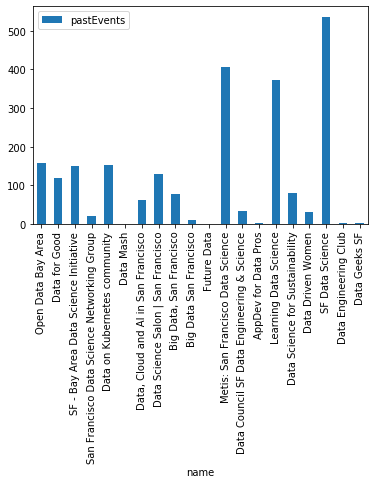

In [58]:
# Distribution of past events for each group

df.plot.bar(y="pastEvents", x="name")

We've seen that the response data from a GraphQL request is a dict / list of dicts and how to work with that data in a DataFrame. Let's see how to incorporate that data into other data science tooling, in this case with Neo4j.

# Graph Data Science With Neo4j Sandbox

Neo4j is a graph database 
Graph Data Science in the cloud

Sign up for a free Neo4j Sandbox at dev.neo4j.com/sandbox (then "Launch the Free Sandbox" button)

Select the "Blank Sandbox"

<!-- ![](../img/sandbox_usecase.png) -->


Grab your sandbox credentials

![](../img/sandbox_creds.png)

We'll be using the Neo4j Python driver


```
pip install neo4j-driver
```



In [68]:
# Replace with your own credentials or set environment variables
NEO4J_URI = os.getenv('NEO4J_URI')
NEO4J_USER = os.getenv('NEO4J_USER')
NEO4J_PASSWORD = os.getenv('NEO4J_PASSWORD')

In [69]:
from neo4j import GraphDatabase, basic_auth

driver = GraphDatabase.driver(NEO4J_URI, auth=basic_auth(NEO4J_USER, NEO4J_PASSWORD))

In [70]:
# Test query - return number of nodes in the database
cypher_query = """
MATCH (a) RETURN COUNT(a) AS num
"""

with driver.session() as session:
    results = session.read_transaction(
        lambda tx: tx.run(cypher_query).data()
    )
    for record in results:
        print("Number of nodes: ", record["num"])



Number of nodes:  121


In [35]:
# Load our Groups and Topics data
load_groups_query = """
UNWIND $data AS row
WITH row.node.result AS group
MERGE (g:Group {name: group.name})
SET g.urlname    = group.urlname,
    g.eventCount = group.pastEvents.count

FOREACH (topic IN group.topics |
  MERGE (t:Topic {name: topic.name})
  MERGE (g)-[:HAS_TOPIC]->(t)
)

RETURN COUNT(*) AS num_groups
"""

with driver.session() as session:
    results = session.write_transaction(
        lambda tx: tx.run(load_groups_query, data=groups_list).data()
    )
    for record in results:
        print(record)

{'num_groups': 20}



We can visualize the results using tools like [Neo4j Bloom.](https://neo4j.com/product/bloom/)

TODO: insert image of launching Neo4j Bloom from Sandbox instance.

![](../img/bloom_1.png)
 however we can improve our ability to analyze the network of groups and topics using graph algorithms.


In [34]:
# TODO: compute centrality (degree?) then style in Bloom
degree_query = """
MATCH (t:Topic)
WITH t, SIZE( (t)<-[:HAS_TOPIC]-(:Group) ) AS degree
SET t.degree = degree
RETURN COUNT(*) AS num_updated
"""

with driver.session() as session:
    results = session.write_transaction(
        lambda tx: tx.run(degree_query).data()
    )
    for record in results:
        print(record)

{'num_updated': 98}


We can use the degree centrality property value to style our graph visualization, allowing us to see the most important topics at a glance.

![](../img/bloom_2.png)

In [37]:
# Create a graph for Graph Data Science
project_gds_query = """
CALL gds.graph.project(
    'topics',
    ['Group','Topic'],
    'HAS_TOPIC'
)
YIELD
    graphName, nodeCount, relationshipCount
RETURN *
"""

with driver.session() as session:
    results = session.write_transaction(
        lambda tx: tx.run(project_gds_query).data()
    )
    for record in results:
        print(record)

{'graphName': 'topic', 'nodeCount': 118, 'relationshipCount': 237}


Let's use the node similarity algorithm to find similar nodes based on topics.

![](../img/similar.png)

In [40]:
# Node similarity algorithm
node_similarity = """
CALL gds.nodeSimilarity.write(
    'topics',
    {
        topK: 3,
        writeRelationshipType: 'SIMILAR',
        writeProperty: 'score'
    }
)
YIELD nodesCompared, relationshipsWritten
"""

with driver.session() as session:
    results = session.write_transaction(
        lambda tx: tx.run(node_similarity).data()
    )
    for record in results:
        print(record)

{'nodesCompared': 20, 'relationshipsWritten': 60}


In [7]:
# Finally close the database driver 
driver.close()

Next, let's see how to use GraphQL to create an API that will show recommended groups using the node similarity graph algorithm.